In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import pickle
from tqdm import tqdm
import copy

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd

In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [5]:
from utils.model import BayesianCNNSingleFC

In [6]:
from bitflip import bitflip_float32

In [7]:
def load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    torch.manual_seed(42)
    
    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [8]:
train_loader, test_loader = load_data(batch_size=54)

In [9]:
device = torch.device("cuda")

In [10]:
num_classes = 10

In [11]:
bayesian_model =BayesianCNNSingleFC(num_classes=num_classes, device=device).to(device)

In [12]:
model_path = 'results_eurosat/bayesian_cnn_model_std10_100_epoch.pth'
guide_path = 'results_eurosat/bayesian_cnn_guide_std10_100_epoch_guide.pth'
pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_100_epoch.pkl'

#guide = AutoDiagonalNormal(bayesian_model).to(device)

#pyro.get_param_store().set_state(torch.load(pyro_param_store_path,weights_only=False))

#original_param_store = {}

#for name, value in pyro.get_param_store().items():
#    print(f"{name}: {value.shape}")
#    original_param_store[name] = torch.tensor(value.data, requires_grad=value.requires_grad)

In [13]:
class Injector:
    def __init__(self, trained_model, device, test_loader, num_samples):
        """
        Initializes SEU injector
        """

        #initialize device
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        self.trained_model = trained_model.to(self.device)
        self.test_loader = test_loader
        self.trained_model.eval()
        self.num_samples = num_samples
        
        self.guide = AutoDiagonalNormal(self.trained_model).to(self.device)
        pyro.get_param_store().clear()
        pyro.get_param_store().set_state(torch.load(pyro_param_store_path,weights_only=False))

        #initial_Accuracy = self.return_accuracy(num_samples)
        initial_labels, initial_predictions, initial_logits, initial_probs = self.predict_data_probs(self.num_samples)
        self.initial_accuracy = self.return_accuracy(initial_labels, initial_predictions)
        
        #print accuracy before SEU
        print(f"Initial accuracy: {self.initial_accuracy}")
        
    def predict_data_probs(self, num_samples=10):
        all_labels = []
        all_predictions = []
        all_logits = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Evaluating"):
                images, labels = images.to(self.device), labels.to(self.device)

                logits_mc = torch.zeros(num_samples, images.size(0), self.trained_model.fc1.out_features).to(device)

                for i in range(num_samples):
                    guide_trace = pyro.poutine.trace(self.guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(self.trained_model, trace=guide_trace)
                    logits = replayed_model(images)
                    logits_mc[i] = logits

                avg_logits = logits_mc.mean(dim=0)
                predictions = torch.argmax(avg_logits, dim=1)

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
                all_logits.extend(avg_logits.cpu().numpy())
                all_probs.extend(F.softmax(avg_logits, dim=1).cpu().numpy())

        return all_labels, all_predictions, all_logits, all_probs

    def return_accuracy(self, all_labels, all_predictions):
        #all_labels, all_predictions, all_logits, all_probs = self.predict_data_probs(num_samples)
        cm = confusion_matrix(all_labels, all_predictions)
        accuracy = np.trace(cm) / np.sum(cm)

        return accuracy
    
    def run_seu_autodiagonal_normal(self, location_index, bit_i, parameter_name="loc", num_samples=10):
        """
        Run SEU on the AutoDiagonalNormal guide
        """

        assert parameter_name in ["loc", "scale"], "Parameter name must be 'loc' or 'scale'."
        assert bit_i in range(0, 33), "Location index must be between 0 and 9."

        if parameter_name == "loc":
            param_store_name = "AutoDiagonalNormal.loc"
        elif parameter_name == "scale":
            param_store_name = "AutoDiagonalNormal.scale"

        pyro.get_param_store().set_state(torch.load(pyro_param_store_path,weights_only=False))

        with torch.no_grad():
            param_dict = {}

            for name, value in pyro.get_param_store().items():
                #print(f"{name}: {value.shape}")
                #print(value)
                param_dict[name] = value.cpu().detach().numpy()

            tensor_cpu = param_dict[param_store_name]

            #original_val = tensor_cpu[0] #this zero index should be changed to the location_index
            original_val = tensor_cpu[location_index]
            seu_val = bitflip_float32(original_val, bit_i)


            print(f"Original value: {original_val}, SEU value: {seu_val}")

            # Get the parameter
            param = pyro.get_param_store().get_param(param_store_name)

            # Modify it safely by creating a new tensor
            new_param = param.clone()
            new_param[location_index] = seu_val  # New Value

            # Update the parameter store
            if parameter_name == "loc":
                pyro.get_param_store().__setitem__(param_store_name, new_param) # 74%
                #param_store[param_store_name].data.copy_(change_item(param_store_name, location_index, seu_val)) #25%
                #pyro.get_param_store()[param_store_name].data[location_index] = seu_val # 25%
            elif parameter_name == "scale":
                pyro.get_param_store().__setitem__(param_store_name, new_param) #10%
                #pyro.get_param_store()[param_store_name].data[location_index] = seu_val

        #print accuracy after SEU
        self.guide = AutoDiagonalNormal(bayesian_model).to(device)
    

        try:
            after_labels, after_predictions, after_logits, after_probs = self.predict_data_probs(num_samples)
            accuracyAfter_SEU = self.return_accuracy(after_labels, after_predictions)
        except:
            accuracyAfter_SEU = np.nan
            
        print(f"Accuracy after SEU: {accuracyAfter_SEU}")
        print("===================================")

        return accuracyAfter_SEU - self.initial_accuracy

In [14]:
inj = Injector(trained_model=bayesian_model, device=device, test_loader=test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]

Initial accuracy: 0.7490740740740741


In [ ]:
#inj.run_seu_autodiagonal_normal(location_index=0, bit_i=1, parameter_name="scale", num_samples=10)
inj.run_seu_autodiagonal_normal(location_index=0, bit_i=2, parameter_name="loc", num_samples=10)

In [ ]:
#store the result in dataframe
import pandas as pd
results = []

for i in range(0, 32):
    results.append(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=i, parameter_name="scale", num_samples=10))

In [ ]:
# plot the result in matplotlib
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results, marker='o')
plt.title('SEU Impact on Scale Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [15]:
results_loc = []

for i in range(0, 32):
    results_loc.append(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=i, parameter_name="loc", num_samples=10))

Original value: 3.148340940475464, SEU value: -3.148340940475464


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


Accuracy after SEU: 0.7403703703703703
Original value: 3.148340940475464, SEU value: 6.749341441734302e-39


Evaluating: 100%|██████████| 100/100 [00:11<00:00,  8.75it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 3.148340940475464, SEU value: 5.807663958573292e+19


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Accuracy after SEU: 0.25055555555555553
Original value: 3.148340940475464, SEU value: 13522021376.0


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Accuracy after SEU: 0.24851851851851853
Original value: 3.148340940475464, SEU value: 206329.671875


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Accuracy after SEU: 0.25037037037037035
Original value: 3.148340940475464, SEU value: 805.9752807617188


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


Accuracy after SEU: 0.28
Original value: 3.148340940475464, SEU value: 50.37345504760742


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Accuracy after SEU: 0.5637037037037037
Original value: 3.148340940475464, SEU value: 12.593363761901855


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


Accuracy after SEU: 0.7174074074074074
Original value: 3.148340940475464, SEU value: 6.296681880950928


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 3.148340940475464, SEU value: 2.148340940475464


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Accuracy after SEU: 0.7472222222222222
Original value: 3.148340940475464, SEU value: 3.648340940475464


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.56it/s]


Accuracy after SEU: 0.7503703703703704
Original value: 3.148340940475464, SEU value: 3.398340940475464


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Accuracy after SEU: 0.75
Original value: 3.148340940475464, SEU value: 3.023340940475464


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


Accuracy after SEU: 0.7472222222222222
Original value: 3.148340940475464, SEU value: 3.210840940475464


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


Accuracy after SEU: 0.7457407407407407
Original value: 3.148340940475464, SEU value: 3.179590940475464


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


Accuracy after SEU: 0.7512962962962964
Original value: 3.148340940475464, SEU value: 3.132715940475464


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Accuracy after SEU: 0.7494444444444445
Original value: 3.148340940475464, SEU value: 3.156153440475464


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Accuracy after SEU: 0.7481481481481481
Original value: 3.148340940475464, SEU value: 3.144434690475464


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Accuracy after SEU: 0.7466666666666667
Original value: 3.148340940475464, SEU value: 3.146387815475464


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


Accuracy after SEU: 0.7462962962962963
Original value: 3.148340940475464, SEU value: 3.147364377975464


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 3.148340940475464, SEU value: 3.147852659225464


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


Accuracy after SEU: 0.7479629629629629
Original value: 3.148340940475464, SEU value: 3.148096799850464


Evaluating: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


Accuracy after SEU: 0.7472222222222222
Original value: 3.148340940475464, SEU value: 3.148218870162964


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Accuracy after SEU: 0.7505555555555555
Original value: 3.148340940475464, SEU value: 3.148401975631714


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


Accuracy after SEU: 0.7468518518518519
Original value: 3.148340940475464, SEU value: 3.148371458053589


Evaluating: 100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


Accuracy after SEU: 0.7501851851851852
Original value: 3.148340940475464, SEU value: 3.1483256816864014


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 3.148340940475464, SEU value: 3.1483333110809326


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


Accuracy after SEU: 0.7514814814814815
Original value: 3.148340940475464, SEU value: 3.1483447551727295


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 3.148340940475464, SEU value: 3.148339033126831


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


Accuracy after SEU: 0.7459259259259259
Original value: 3.148340940475464, SEU value: 3.1483418941497803


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 3.148340940475464, SEU value: 3.1483404636383057


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 3.148340940475464, SEU value: 3.1483407020568848


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]

Accuracy after SEU: 0.7494444444444445


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [ ]:
#(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=0, parameter_name="loc", num_samples=10))

In [16]:
results2_loc = []

for i in range(0, 32):
    results2_loc.append(inj.run_seu_autodiagonal_normal(location_index=217536, bit_i=i, parameter_name="loc", num_samples=10))

Original value: 3.2035176753997803, SEU value: -3.2035176753997803


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


Accuracy after SEU: 0.7503703703703704
Original value: 3.2035176753997803, SEU value: 7.073641142736066e-39


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


Accuracy after SEU: 0.7501851851851852
Original value: 3.2035176753997803, SEU value: 5.9094470693704696e+19


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Accuracy after SEU: 0.1111111111111111
Original value: 3.2035176753997803, SEU value: 13759003648.0


Evaluating: 100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


Accuracy after SEU: 0.1111111111111111
Original value: 3.2035176753997803, SEU value: 209945.734375


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


Accuracy after SEU: 0.24962962962962962
Original value: 3.2035176753997803, SEU value: 820.1005249023438


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 3.2035176753997803, SEU value: 51.256282806396484


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Accuracy after SEU: 0.7501851851851852
Original value: 3.2035176753997803, SEU value: 12.814070701599121


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Accuracy after SEU: 0.7481481481481481
Original value: 3.2035176753997803, SEU value: 6.4070353507995605


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


Accuracy after SEU: 0.7487037037037036
Original value: 3.2035176753997803, SEU value: 2.2035176753997803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


Accuracy after SEU: 0.7514814814814815
Original value: 3.2035176753997803, SEU value: 3.7035176753997803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 3.2035176753997803, SEU value: 3.4535176753997803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Accuracy after SEU: 0.7474074074074074
Original value: 3.2035176753997803, SEU value: 3.0785176753997803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Accuracy after SEU: 0.75
Original value: 3.2035176753997803, SEU value: 3.1410176753997803


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Accuracy after SEU: 0.7468518518518519
Original value: 3.2035176753997803, SEU value: 3.2347676753997803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.7479629629629629
Original value: 3.2035176753997803, SEU value: 3.1878926753997803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Accuracy after SEU: 0.7503703703703704
Original value: 3.2035176753997803, SEU value: 3.2113301753997803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Accuracy after SEU: 0.7507407407407407
Original value: 3.2035176753997803, SEU value: 3.2074239253997803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Accuracy after SEU: 0.7503703703703704
Original value: 3.2035176753997803, SEU value: 3.2054708003997803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


Accuracy after SEU: 0.7481481481481481
Original value: 3.2035176753997803, SEU value: 3.2044942378997803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 3.2035176753997803, SEU value: 3.2040059566497803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.7462962962962963
Original value: 3.2035176753997803, SEU value: 3.2032735347747803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.75
Original value: 3.2035176753997803, SEU value: 3.2033956050872803


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Accuracy after SEU: 0.7496296296296296
Original value: 3.2035176753997803, SEU value: 3.2035787105560303


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Accuracy after SEU: 0.7512962962962964
Original value: 3.2035176753997803, SEU value: 3.2035481929779053


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Accuracy after SEU: 0.7520370370370371
Original value: 3.2035176753997803, SEU value: 3.2035024166107178


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Accuracy after SEU: 0.7501851851851852
Original value: 3.2035176753997803, SEU value: 3.203510046005249


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Accuracy after SEU: 0.7494444444444445
Original value: 3.2035176753997803, SEU value: 3.203521490097046


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 3.2035176753997803, SEU value: 3.2035157680511475


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 3.2035176753997803, SEU value: 3.203516721725464


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.7453703703703703
Original value: 3.2035176753997803, SEU value: 3.203517198562622


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Accuracy after SEU: 0.7468518518518519
Original value: 3.2035176753997803, SEU value: 3.203517436981201


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]

Accuracy after SEU: 0.7466666666666667


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results2_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [ ]:
bayesian_model

In [ ]:
# print the parameters of the bayesian model
for name, value in bayesian_model.named_parameters():
    print(f"{name}: {value.shape}")

In [ ]:
# print the parameters of pyro param store
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.shape}")

In [17]:
results3_loc = []

for i in range(0, 32):
    results3_loc.append(inj.run_seu_autodiagonal_normal(location_index=53696, bit_i=i, parameter_name="loc", num_samples=10))

Original value: -3.9885945320129395, SEU value: 3.9885945320129395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Accuracy after SEU: 0.7505555555555555
Original value: -3.9885945320129395, SEU value: -1.1687908192286504e-38


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Accuracy after SEU: 0.7505555555555555
Original value: -3.9885945320129395, SEU value: -7.357658254584001e+19


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.7446296296296296
Original value: -3.9885945320129395, SEU value: -17130883072.0


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Accuracy after SEU: 0.7492592592592593
Original value: -3.9885945320129395, SEU value: -261396.53125


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Accuracy after SEU: 0.7472222222222222
Original value: -3.9885945320129395, SEU value: -1021.0802001953125


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Accuracy after SEU: 0.7494444444444445
Original value: -3.9885945320129395, SEU value: -63.81751251220703


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Accuracy after SEU: 0.75
Original value: -3.9885945320129395, SEU value: -15.954378128051758


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


Accuracy after SEU: 0.7483333333333333
Original value: -3.9885945320129395, SEU value: -7.977189064025879


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.7505555555555555
Original value: -3.9885945320129395, SEU value: -2.9885945320129395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.7498148148148148
Original value: -3.9885945320129395, SEU value: -3.4885945320129395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Accuracy after SEU: 0.7479629629629629
Original value: -3.9885945320129395, SEU value: -3.7385945320129395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


Accuracy after SEU: 0.7492592592592593
Original value: -3.9885945320129395, SEU value: -3.8635945320129395


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


Accuracy after SEU: 0.7503703703703704
Original value: -3.9885945320129395, SEU value: -3.9260945320129395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Accuracy after SEU: 0.7496296296296296
Original value: -3.9885945320129395, SEU value: -3.9573445320129395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


Accuracy after SEU: 0.7472222222222222
Original value: -3.9885945320129395, SEU value: -3.9729695320129395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Accuracy after SEU: 0.7498148148148148
Original value: -3.9885945320129395, SEU value: -3.9964070320129395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


Accuracy after SEU: 0.7496296296296296
Original value: -3.9885945320129395, SEU value: -3.9846882820129395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Accuracy after SEU: 0.7466666666666667
Original value: -3.9885945320129395, SEU value: -3.9905476570129395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


Accuracy after SEU: 0.7496296296296296
Original value: -3.9885945320129395, SEU value: -3.9895710945129395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.7481481481481481
Original value: -3.9885945320129395, SEU value: -3.9890828132629395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.7505555555555555
Original value: -3.9885945320129395, SEU value: -3.9883503913879395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Accuracy after SEU: 0.7505555555555555
Original value: -3.9885945320129395, SEU value: -3.9887166023254395


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Accuracy after SEU: 0.7505555555555555
Original value: -3.9885945320129395, SEU value: -3.9885334968566895


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Accuracy after SEU: 0.7490740740740741
Original value: -3.9885945320129395, SEU value: -3.9886250495910645


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.7520370370370371
Original value: -3.9885945320129395, SEU value: -3.988609790802002


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Accuracy after SEU: 0.7498148148148148
Original value: -3.9885945320129395, SEU value: -3.988586902618408


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Accuracy after SEU: 0.7485185185185185
Original value: -3.9885945320129395, SEU value: -3.988598346710205


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.7479629629629629
Original value: -3.9885945320129395, SEU value: -3.9885964393615723


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Accuracy after SEU: 0.7505555555555555
Original value: -3.9885945320129395, SEU value: -3.988595485687256


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Accuracy after SEU: 0.7514814814814815
Original value: -3.9885945320129395, SEU value: -3.9885940551757812


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


Accuracy after SEU: 0.7490740740740741
Original value: -3.9885945320129395, SEU value: -3.9885947704315186


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]

Accuracy after SEU: 0.7505555555555555


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results3_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [ ]:
import numpy as np

def get_flat_param_index(layer_name, param_type, index_tuple):
    # Define parameter shapes for each layer
    param_shapes = {
        'conv1': {
            'weight': (32, 3, 5, 5),
            'bias': (32,)
        },
        'conv2': {
            'weight': (64, 32, 5, 5),
            'bias': (64,)
        },
        'fc1': {
            'weight': (10, 16384),
            'bias': (10,)
        }
    }

    # Check valid inputs
    if layer_name not in param_shapes:
        raise ValueError(f"Unknown layer '{layer_name}'")
    if param_type not in param_shapes[layer_name]:
        raise ValueError(f"'{param_type}' not found in layer '{layer_name}'")

    # Compute flat offset for each param in order: conv1.weight, conv1.bias, ...
    flat_offset = 0
    for l in ['conv1', 'conv2', 'fc1']:
        for p in ['weight', 'bias']:
            shape = param_shapes[l][p]
            numel = np.prod(shape)

            if l == layer_name and p == param_type:
                # Compute local flat index within this param
                local_flat_index = np.ravel_multi_index(index_tuple, shape)
                return flat_offset + local_flat_index

            flat_offset += numel

    raise RuntimeError("Should not reach here if input is valid.")


In [ ]:
# Index of conv1.bias[5]
print(get_flat_param_index("conv1", "bias", (0,)))  # Output: 2405

# Index of conv2.weight[0,0,0,0]
print(get_flat_param_index("conv2", "weight", (0,0,0,0)))  # Output: 2432

# Index of fc1.weight[0, 0]
print(get_flat_param_index("fc1", "weight", (0, 0)))  # Output: 53696

In [18]:
results4_loc = []

for i in range(0, 32):
    results4_loc.append(inj.run_seu_autodiagonal_normal(location_index=2400, bit_i=i, parameter_name="loc", num_samples=10))

Original value: 2.013899326324463, SEU value: -2.013899326324463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Accuracy after SEU: 0.7438888888888889
Original value: 2.013899326324463, SEU value: 8.169289787320819e-41


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Accuracy after SEU: 0.7451851851851852
Original value: 2.013899326324463, SEU value: 3.7149885462923444e+19


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


Accuracy after SEU: 0.1111111111111111
Original value: 2.013899326324463, SEU value: 8649631744.0


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Accuracy after SEU: 0.1111111111111111
Original value: 2.013899326324463, SEU value: 131982.90625


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Accuracy after SEU: 0.1111111111111111
Original value: 2.013899326324463, SEU value: 515.5582275390625


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Accuracy after SEU: 0.11203703703703703
Original value: 2.013899326324463, SEU value: 32.222389221191406


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Accuracy after SEU: 0.42962962962962964
Original value: 2.013899326324463, SEU value: 8.055597305297852


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


Accuracy after SEU: 0.7283333333333334
Original value: 2.013899326324463, SEU value: 4.027798652648926


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Accuracy after SEU: 0.7503703703703704
Original value: 2.013899326324463, SEU value: 3.013899326324463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Accuracy after SEU: 0.7511111111111111
Original value: 2.013899326324463, SEU value: 2.513899326324463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 2.013899326324463, SEU value: 2.263899326324463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Accuracy after SEU: 0.7487037037037036
Original value: 2.013899326324463, SEU value: 2.138899326324463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 2.013899326324463, SEU value: 2.076399326324463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.7487037037037036
Original value: 2.013899326324463, SEU value: 2.045149326324463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 2.013899326324463, SEU value: 2.029524326324463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 2.013899326324463, SEU value: 2.006086826324463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Accuracy after SEU: 0.7494444444444445
Original value: 2.013899326324463, SEU value: 2.009993076324463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Accuracy after SEU: 0.7481481481481481
Original value: 2.013899326324463, SEU value: 2.011946201324463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


Accuracy after SEU: 0.7479629629629629
Original value: 2.013899326324463, SEU value: 2.014875888824463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.7496296296296296
Original value: 2.013899326324463, SEU value: 2.014387607574463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.7496296296296296
Original value: 2.013899326324463, SEU value: 2.014143466949463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.7488888888888889
Original value: 2.013899326324463, SEU value: 2.013777256011963


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Accuracy after SEU: 0.7511111111111111
Original value: 2.013899326324463, SEU value: 2.013838291168213


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.7475925925925926
Original value: 2.013899326324463, SEU value: 2.013868808746338


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Accuracy after SEU: 0.75
Original value: 2.013899326324463, SEU value: 2.0139145851135254


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Accuracy after SEU: 0.7509259259259259
Original value: 2.013899326324463, SEU value: 2.0138916969299316


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 2.013899326324463, SEU value: 2.0138955116271973


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


Accuracy after SEU: 0.747037037037037
Original value: 2.013899326324463, SEU value: 2.01389741897583


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 2.013899326324463, SEU value: 2.0139002799987793


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.7524074074074074
Original value: 2.013899326324463, SEU value: 2.0138988494873047


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Accuracy after SEU: 0.7448148148148148
Original value: 2.013899326324463, SEU value: 2.013899564743042


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Accuracy after SEU: 0.7472222222222222


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results4_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

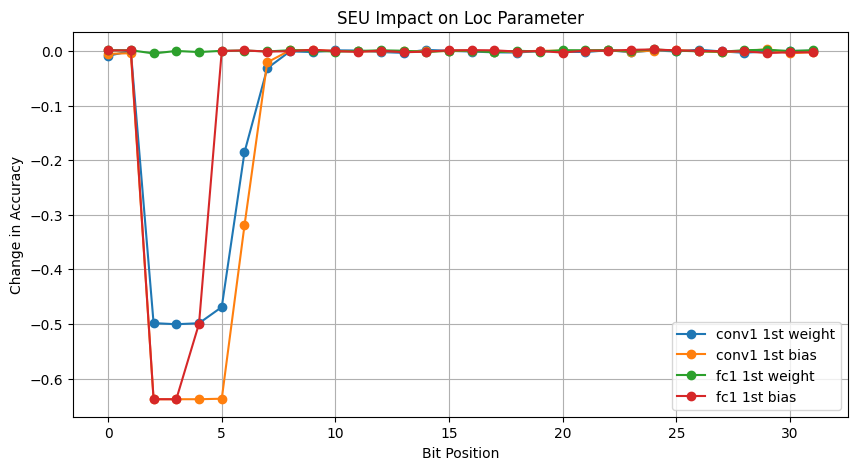

In [19]:
# plot results2_loc, results3_loc, results4_loc in a single plot
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results_loc, marker='o', label='conv1 1st weight')
plt.plot(range(0, 32), results4_loc, marker='o', label='conv1 1st bias')
plt.plot(range(0, 32), results3_loc, marker='o', label='fc1 1st weight')
plt.plot(range(0, 32), results2_loc, marker='o', label='fc1 1st bias')


plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#results
#results2_scale
#...
#...

In [20]:
results_scale = []

for i in range(0, 32):
    results_scale.append(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=i, parameter_name="scale", num_samples=10))

Original value: 0.04540996998548508, SEU value: -0.04540996998548508


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Accuracy after SEU: nan
Original value: 0.04540996998548508, SEU value: 1.5452212068469636e+37


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Accuracy after SEU: 0.1111111111111111
Original value: 0.04540996998548508, SEU value: 2.4616794055382235e-21


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 0.04540996998548508, SEU value: 1.0572832540023391e-11


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Accuracy after SEU: 0.7509259259259259
Original value: 0.04540996998548508, SEU value: 6.92901153342973e-07


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.26it/s]


Accuracy after SEU: 0.7475925925925926
Original value: 0.04540996998548508, SEU value: 0.00017738269525580108


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Accuracy after SEU: 0.7501851851851852
Original value: 0.04540996998548508, SEU value: 0.7265595197677612


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Accuracy after SEU: 0.7498148148148148
Original value: 0.04540996998548508, SEU value: 0.01135249249637127


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Accuracy after SEU: 0.7496296296296296
Original value: 0.04540996998548508, SEU value: 0.09081993997097015


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Accuracy after SEU: 0.7479629629629629
Original value: 0.04540996998548508, SEU value: 0.06103496998548508


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Accuracy after SEU: 0.7496296296296296
Original value: 0.04540996998548508, SEU value: 0.03759746998548508


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Accuracy after SEU: 0.7509259259259259
Original value: 0.04540996998548508, SEU value: 0.04150371998548508


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 0.04540996998548508, SEU value: 0.04345684498548508


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.7511111111111111
Original value: 0.04540996998548508, SEU value: 0.04638653248548508


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 0.04540996998548508, SEU value: 0.04589825123548508


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Accuracy after SEU: 0.7520370370370371
Original value: 0.04540996998548508, SEU value: 0.04516582936048508


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


Accuracy after SEU: 0.7494444444444445
Original value: 0.04540996998548508, SEU value: 0.04528789967298508


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


Accuracy after SEU: 0.7488888888888889
Original value: 0.04540996998548508, SEU value: 0.04534893482923508


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.26it/s]


Accuracy after SEU: 0.7477777777777778
Original value: 0.04540996998548508, SEU value: 0.04537945240736008


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Accuracy after SEU: 0.7488888888888889
Original value: 0.04540996998548508, SEU value: 0.04539471119642258


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Accuracy after SEU: 0.7481481481481481
Original value: 0.04540996998548508, SEU value: 0.04540234059095383


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.7487037037037036
Original value: 0.04540996998548508, SEU value: 0.04540615528821945


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


Accuracy after SEU: 0.7498148148148148
Original value: 0.04540996998548508, SEU value: 0.045408062636852264


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


Accuracy after SEU: 0.7472222222222222
Original value: 0.04540996998548508, SEU value: 0.04540901631116867


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Accuracy after SEU: 0.7455555555555555
Original value: 0.04540996998548508, SEU value: 0.045409493148326874


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 0.04540996998548508, SEU value: 0.045409731566905975


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 0.04540996998548508, SEU value: 0.04541008919477463


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Accuracy after SEU: 0.7503703703703704
Original value: 0.04540996998548508, SEU value: 0.04541002959012985


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Accuracy after SEU: 0.7488888888888889
Original value: 0.04540996998548508, SEU value: 0.04540994018316269


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 0.04540996998548508, SEU value: 0.04540995508432388


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Accuracy after SEU: 0.7468518518518519
Original value: 0.04540996998548508, SEU value: 0.04540996253490448


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Accuracy after SEU: 0.7501851851851852
Original value: 0.04540996998548508, SEU value: 0.045409973710775375


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]

Accuracy after SEU: 0.7490740740740741


In [21]:
#store the result in dataframe
import pandas as pd
results2_scale = []

for i in range(0, 32):
    results2_scale.append(inj.run_seu_autodiagonal_normal(location_index=217536, bit_i=i, parameter_name="scale", num_samples=10))

Original value: 6.365564346313477, SEU value: -6.365564346313477


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Accuracy after SEU: nan
Original value: 6.365564346313477, SEU value: 1.8706712322218148e-38


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 6.365564346313477, SEU value: 1.1742393638117494e+20


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Accuracy after SEU: 0.3964814814814815
Original value: 6.365564346313477, SEU value: 27339890688.0


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Accuracy after SEU: 0.4001851851851852
Original value: 6.365564346313477, SEU value: 417173.625


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.5474074074074075
Original value: 6.365564346313477, SEU value: 1629.58447265625


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 6.365564346313477, SEU value: 101.84902954101562


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.7496296296296296
Original value: 6.365564346313477, SEU value: 25.462257385253906


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


Accuracy after SEU: 0.7496296296296296
Original value: 6.365564346313477, SEU value: 3.1827821731567383


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Accuracy after SEU: 0.747037037037037
Original value: 6.365564346313477, SEU value: 4.365564346313477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 6.365564346313477, SEU value: 7.365564346313477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Accuracy after SEU: 0.7468518518518519
Original value: 6.365564346313477, SEU value: 6.865564346313477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 6.365564346313477, SEU value: 6.115564346313477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 6.365564346313477, SEU value: 6.490564346313477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Accuracy after SEU: 0.747037037037037
Original value: 6.365564346313477, SEU value: 6.303064346313477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


Accuracy after SEU: 0.7507407407407407
Original value: 6.365564346313477, SEU value: 6.334314346313477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Accuracy after SEU: 0.7505555555555555
Original value: 6.365564346313477, SEU value: 6.349939346313477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Accuracy after SEU: 0.7496296296296296
Original value: 6.365564346313477, SEU value: 6.373376846313477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


Accuracy after SEU: 0.7477777777777778
Original value: 6.365564346313477, SEU value: 6.361658096313477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Accuracy after SEU: 0.7466666666666667
Original value: 6.365564346313477, SEU value: 6.363611221313477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Accuracy after SEU: 0.745
Original value: 6.365564346313477, SEU value: 6.366540908813477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.7501851851851852
Original value: 6.365564346313477, SEU value: 6.366052627563477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Accuracy after SEU: 0.7516666666666667
Original value: 6.365564346313477, SEU value: 6.365320205688477


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Accuracy after SEU: 0.7488888888888889
Original value: 6.365564346313477, SEU value: 6.365686416625977


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 6.365564346313477, SEU value: 6.365503311157227


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.7468518518518519
Original value: 6.365564346313477, SEU value: 6.365594863891602


Evaluating: 100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


Accuracy after SEU: 0.7509259259259259
Original value: 6.365564346313477, SEU value: 6.365549087524414


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


Accuracy after SEU: 0.7475925925925926
Original value: 6.365564346313477, SEU value: 6.365556716918945


Evaluating: 100%|██████████| 100/100 [00:21<00:00,  4.71it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 6.365564346313477, SEU value: 6.365568161010742


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


Accuracy after SEU: 0.7488888888888889
Original value: 6.365564346313477, SEU value: 6.365562438964844


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Accuracy after SEU: 0.7524074074074074
Original value: 6.365564346313477, SEU value: 6.365565299987793


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Accuracy after SEU: 0.7466666666666667
Original value: 6.365564346313477, SEU value: 6.365564823150635


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]

Accuracy after SEU: 0.7483333333333333


In [22]:
#store the result in dataframe
import pandas as pd
results3_scale = []

for i in range(0, 32):
    results3_scale.append(inj.run_seu_autodiagonal_normal(location_index=53696, bit_i=i, parameter_name="scale", num_samples=10))

Original value: 3.083939552307129, SEU value: -3.083939552307129


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Accuracy after SEU: nan
Original value: 3.083939552307129, SEU value: 6.370824101849347e-39


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


Accuracy after SEU: 0.7542592592592593
Original value: 3.083939552307129, SEU value: 5.688864366020002e+19


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.91it/s]


Accuracy after SEU: 0.7375925925925926
Original value: 3.083939552307129, SEU value: 13245419520.0


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


Accuracy after SEU: 0.7377777777777778
Original value: 3.083939552307129, SEU value: 202109.0625


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


Accuracy after SEU: 0.7412962962962963
Original value: 3.083939552307129, SEU value: 789.488525390625


Evaluating: 100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


Accuracy after SEU: 0.7488888888888889
Original value: 3.083939552307129, SEU value: 49.34303283691406


Evaluating: 100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


Accuracy after SEU: 0.7509259259259259
Original value: 3.083939552307129, SEU value: 12.335758209228516


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


Accuracy after SEU: 0.7477777777777778
Original value: 3.083939552307129, SEU value: 6.167879104614258


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 3.083939552307129, SEU value: 2.083939552307129


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


Accuracy after SEU: 0.7512962962962964
Original value: 3.083939552307129, SEU value: 3.583939552307129


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 3.083939552307129, SEU value: 3.333939552307129


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 3.083939552307129, SEU value: 3.208939552307129


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Accuracy after SEU: 0.7459259259259259
Original value: 3.083939552307129, SEU value: 3.021439552307129


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Accuracy after SEU: 0.7487037037037036
Original value: 3.083939552307129, SEU value: 3.115189552307129


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Accuracy after SEU: 0.7451851851851852
Original value: 3.083939552307129, SEU value: 3.068314552307129


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.7466666666666667
Original value: 3.083939552307129, SEU value: 3.091752052307129


Evaluating: 100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 3.083939552307129, SEU value: 3.080033302307129


Evaluating: 100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


Accuracy after SEU: 0.7494444444444445
Original value: 3.083939552307129, SEU value: 3.085892677307129


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


Accuracy after SEU: 0.7488888888888889
Original value: 3.083939552307129, SEU value: 3.082962989807129


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 3.083939552307129, SEU value: 3.083451271057129


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.7477777777777778
Original value: 3.083939552307129, SEU value: 3.083695411682129


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Accuracy after SEU: 0.7475925925925926
Original value: 3.083939552307129, SEU value: 3.083817481994629


Evaluating: 100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


Accuracy after SEU: 0.7475925925925926
Original value: 3.083939552307129, SEU value: 3.083878517150879


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


Accuracy after SEU: 0.7498148148148148
Original value: 3.083939552307129, SEU value: 3.083970069885254


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Accuracy after SEU: 0.7474074074074074
Original value: 3.083939552307129, SEU value: 3.0839242935180664


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


Accuracy after SEU: 0.7466666666666667
Original value: 3.083939552307129, SEU value: 3.08394718170166


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.7511111111111111
Original value: 3.083939552307129, SEU value: 3.0839433670043945


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Accuracy after SEU: 0.7494444444444445
Original value: 3.083939552307129, SEU value: 3.0839414596557617


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


Accuracy after SEU: 0.7509259259259259
Original value: 3.083939552307129, SEU value: 3.0839385986328125


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Accuracy after SEU: 0.7485185185185185
Original value: 3.083939552307129, SEU value: 3.083940029144287


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


Accuracy after SEU: 0.7492592592592593
Original value: 3.083939552307129, SEU value: 3.083939790725708


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.67it/s]

Accuracy after SEU: 0.7511111111111111


In [23]:
#store the result in dataframe
import pandas as pd
results4_scale = []

for i in range(0, 32):
    results4_scale.append(inj.run_seu_autodiagonal_normal(location_index=2400, bit_i=i, parameter_name="scale", num_samples=10))

Original value: 0.06122199073433876, SEU value: -0.06122199073433876


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Accuracy after SEU: nan
Original value: 0.06122199073433876, SEU value: 2.0832763914692557e+37


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Accuracy after SEU: 0.1174074074074074
Original value: 0.06122199073433876, SEU value: 3.3188507679028753e-21


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.68it/s]


Accuracy after SEU: 0.7507407407407407
Original value: 0.06122199073433876, SEU value: 1.4254355508447336e-11


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 0.06122199073433876, SEU value: 9.341734426016046e-07


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


Accuracy after SEU: 0.7481481481481481
Original value: 0.06122199073433876, SEU value: 0.00023914840130601078


Evaluating: 100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


Accuracy after SEU: 0.7522222222222222
Original value: 0.06122199073433876, SEU value: 0.9795518517494202


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.56it/s]


Accuracy after SEU: 0.7512962962962964
Original value: 0.06122199073433876, SEU value: 0.01530549768358469


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Accuracy after SEU: 0.7505555555555555
Original value: 0.06122199073433876, SEU value: 0.12244398146867752


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Accuracy after SEU: 0.7533333333333333
Original value: 0.06122199073433876, SEU value: 0.04559699073433876


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Accuracy after SEU: 0.7481481481481481
Original value: 0.06122199073433876, SEU value: 0.05340949073433876


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


Accuracy after SEU: 0.7479629629629629
Original value: 0.06122199073433876, SEU value: 0.05731574073433876


Evaluating: 100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Accuracy after SEU: 0.7498148148148148
Original value: 0.06122199073433876, SEU value: 0.05926886573433876


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 0.06122199073433876, SEU value: 0.06219855323433876


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.7507407407407407
Original value: 0.06122199073433876, SEU value: 0.06073370948433876


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Accuracy after SEU: 0.7475925925925926
Original value: 0.06122199073433876, SEU value: 0.06146613135933876


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 0.06122199073433876, SEU value: 0.06109992042183876


Evaluating: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


Accuracy after SEU: 0.7479629629629629
Original value: 0.06122199073433876, SEU value: 0.06116095557808876


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


Accuracy after SEU: 0.7488888888888889
Original value: 0.06122199073433876, SEU value: 0.06125250831246376


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Accuracy after SEU: 0.7477777777777778
Original value: 0.06122199073433876, SEU value: 0.06123724952340126


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


Accuracy after SEU: 0.7453703703703703
Original value: 0.06122199073433876, SEU value: 0.06122962012887001


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Accuracy after SEU: 0.7498148148148148
Original value: 0.06122199073433876, SEU value: 0.061225805431604385


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Accuracy after SEU: 0.75
Original value: 0.06122199073433876, SEU value: 0.06122008338570595


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.7459259259259259
Original value: 0.06122199073433876, SEU value: 0.061221037060022354


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 0.06122199073433876, SEU value: 0.06122151389718056


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Accuracy after SEU: 0.7490740740740741
Original value: 0.06122199073433876, SEU value: 0.06122175231575966


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


Accuracy after SEU: 0.7503703703703704
Original value: 0.06122199073433876, SEU value: 0.06122187152504921


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


Accuracy after SEU: 0.7494444444444445
Original value: 0.06122199073433876, SEU value: 0.061222050338983536


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


Accuracy after SEU: 0.7466666666666667
Original value: 0.06122199073433876, SEU value: 0.06122196093201637


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Accuracy after SEU: 0.7462962962962963
Original value: 0.06122199073433876, SEU value: 0.061222005635499954


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Accuracy after SEU: 0.7483333333333333
Original value: 0.06122199073433876, SEU value: 0.06122199818491936


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Accuracy after SEU: 0.747037037037037
Original value: 0.06122199073433876, SEU value: 0.06122198700904846


Evaluating: 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]

Accuracy after SEU: 0.7498148148148148


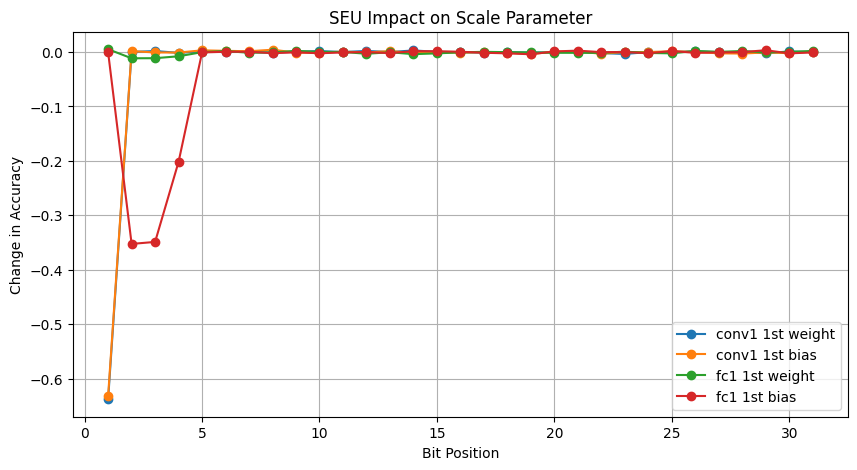

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results_scale, marker='o', label='conv1 1st weight')
plt.plot(range(0, 32), results4_scale, marker='o', label='conv1 1st bias')
plt.plot(range(0, 32), results3_scale, marker='o', label='fc1 1st weight')
plt.plot(range(0, 32), results2_scale, marker='o', label='fc1 1st bias')


plt.title('SEU Impact on Scale Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.legend()
plt.show()